# PyTorch Custom Dataset

Use PyTorch to train models on custom dataset

## Domain Libraries

depending what we're working on, vision, text, audio, recommendation, you'll want to look up into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

## 0. Import PyTorch and setting up device agnostic code

In [ ]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get Data

Our dataset is a subset of Food101 dataset.

In [ ]:
import requests
import zipfile
from pathlib import Path

#Setup path
data_path = Path("data")
image_path = data_path / "pizza_steak_sushi"

#Create folder
if image_path.is_dir():
  print(f"Already exists...")
else:
  print(f"data folder created...")
  image_path.mkdir(parents=True,exist_ok=True)

#Download
with open(data_path/"pizza_steak_sushi.zip","wb") as f:
  req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(req.content)
  print(f"data downloaded...")

with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip","r") as zip_ref:
  zip_ref.extractall(image_path)
  print(f"data extracted...")


data folder created...
data downloaded...
data extracted...


## 2. Data Preparation and Exploration

In [ ]:
import os

def walk_through_dir(dir_path):
  for dirpath,dirnames,filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'


In [ ]:
# Setup our training and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir,test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualising Data

Let's write code to:
1. Get all image paths
2. Pick a random image path using Python's random.choice
3. Get the image class name using `pathlib.Path.parent.stem`
4. Open image using python's PIL
5. Show the image and print metadata

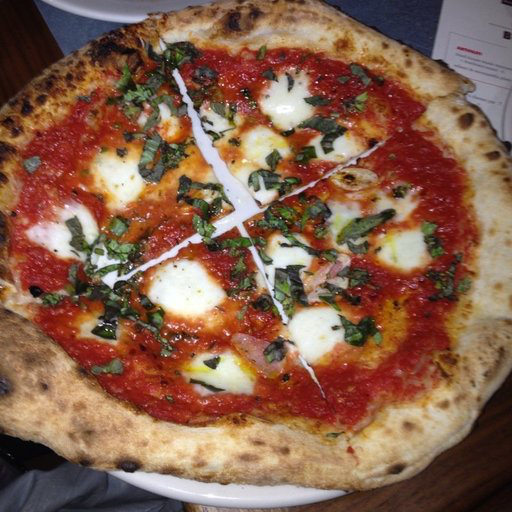

In [ ]:
import random
from PIL import Image

#random.seed(42)

# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Get a random image path
image = random.choice(image_path_list)

# Get image class
image_class = image.parent.stem

# Show the image
with Image.open(image) as img:
  img.show()

(512, 512, 3)

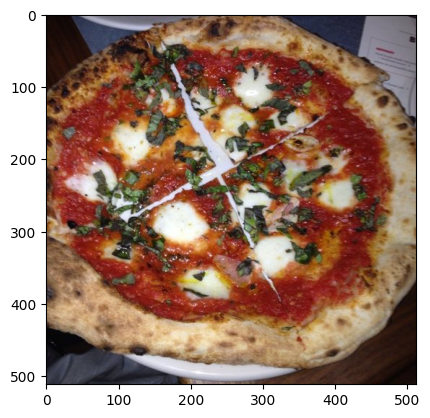

In [ ]:
#Visualise with matplotlib
import matplotlib.pyplot as plt
import numpy as np

img_as_array = np.asarray(img)

plt.imshow(img_as_array)
img_as_array.shape

In [ ]:
img_as_array

array([[[28, 18, 17],
        [26, 16, 15],
        [24, 14, 13],
        ...,
        [22, 10, 20],
        [23, 11, 21],
        [18,  6, 16]],

       [[25, 15, 14],
        [24, 14, 13],
        [22, 12, 11],
        ...,
        [35, 23, 33],
        [30, 18, 28],
        [24, 12, 22]],

       [[22, 12, 11],
        [21, 11, 10],
        [20, 10,  9],
        ...,
        [49, 37, 47],
        [46, 34, 44],
        [43, 31, 41]],

       ...,

       [[65, 66, 84],
        [65, 67, 82],
        [64, 66, 81],
        ...,
        [27, 16, 14],
        [27, 16, 14],
        [27, 16, 14]],

       [[65, 66, 84],
        [65, 67, 82],
        [63, 65, 80],
        ...,
        [28, 17, 15],
        [28, 17, 15],
        [29, 18, 16]],

       [[63, 64, 82],
        [63, 64, 82],
        [61, 63, 78],
        ...,
        [28, 17, 15],
        [29, 18, 16],
        [30, 19, 17]]], dtype=uint8)

## 3. Transforming data

Before we can use our image data with PyTorch:

1. Turn target data into tensors
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
data_transforms = transforms.Compose([
    # Resize to 64x64
    transforms.Resize(size=(64,64)),
    # Flip the images randomly onhorizontal direction -> to increase randomness
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn into tensor
    transforms.ToTensor()
])

In [ ]:
data_transforms(img).shape

torch.Size([3, 64, 64])

Text(0.5, 0.98, 'Class : pizza')

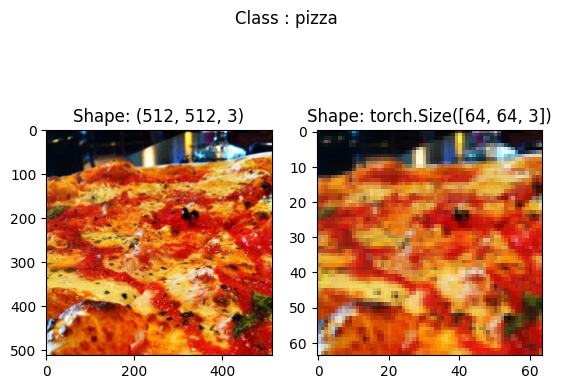

In [ ]:
random_image_path = random.choice(image_path_list)

img = Image.open(random_image_path)

new_img = data_transforms(img).permute(1,2,0)

img_as_array = np.asarray(img)

fig,ax = plt.subplots(1,2)
ax[0].imshow(img_as_array,cmap=plt.cm.RdYlBu)
ax[0].set_title(f"Shape: {img_as_array.shape}")
ax[1].imshow(new_img,cmap=plt.cm.RdYlBu)
ax[1].set_title(f"Shape: {new_img.shape}")
fig.suptitle(f"Class : {random_image_path.parent.stem}")

## 4. Option 1: Loading data using `ImageFolder`

In [ ]:
from torchvision.datasets import ImageFolder

train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transforms,
                                  target_transform=None)# transform for label
test_data = datasets.ImageFolder(root=test_dir,
                                  transform=data_transforms,
                                  target_transform=None)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get classes names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
len(train_data),len(test_data)

(225, 75)

In [ ]:
train_data.samples[0]

('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0)

In [ ]:
image,label = train_data[0]
image.shape,label

(torch.Size([3, 64, 64]), 0)

### 4.1 Turn dataset into DataLoader

In [ ]:
import os
os.cpu_count()

2

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1,
                              shuffle=True,
                              num_workers=1)
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             shuffle=False,
                             num_workers=1)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fce4be71060>,
 <torch.utils.data.dataloader.DataLoader at 0x7fce4be70910>)

In [ ]:
train_batch_features,train_batch_labels = next(iter(train_dataloader))
train_batch_features.shape,train_batch_labels.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 5. Option 2: Custom Dataloading class

1. Want to be able to load images from a file.
2. Want to be able to get class names from the Dataset.
3. Want to be able to get classes as dictionary from the Dataset

Pros:
* Can create a `Dataset` out of almost anything
* Not limited yo PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create a `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` results in us writing more code which could be prone to more errors and performance issues.

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple,Dict,List

In [ ]:
# Instances of torchvision.datasets.ImageFolder()
train_data.classes,train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want the function to:
1. Get class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format)
2. Raise an error if class names are not found
3. Turn class names into dict and list

In [ ]:
target_dir = train_dir
target_dir

PosixPath('data/pizza_steak_sushi/train')

In [ ]:
class_names_found = sorted([entry.name for entry in os.scandir(target_dir)])
class_names_found

['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory:str) -> Tuple[List[str],Dict[str,int]]:
  classes = sorted([entry.name for entry in os.scandir(directory) if entry.is_dir()])
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes")
  class_to_idx = {class_name: i for i,class_name in enumerate(classes)}
  return classes,class_to_idx

In [ ]:
class_names,class_dict = find_classes(target_dir)
class_names,class_dict


(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Custom `Dataset` to implement `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory as well as transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use
  * classes
  * class_to_idx
4. Create a function `load_images()`
5. Overwrite `__len__()` method to return length of the dataset
6. Overwrite `__getitem__()` method

In [ ]:
from torch.utils.data import Dataset

class ImageFolderCustom(Dataset):
  def __init__(self,
               targ_dir:str,
               transform=None):
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    self.transform = transform
    self.classes,self.class_to_idx = find_classes(targ_dir)

  def load_image(self,index:int)-> Image.Image:
    image_path = self.paths[index]
    return Image.open(image_path)

  def __len__(self) -> int:
    return len(self.paths)

  def __getitem__(self,index:int)->Tuple[torch.Tensor,int]:
    if self.transform:
      img = self.transform(self.load_image(index))
    else:
      img = self.load_image(self.paths[index])
    label = self.paths[index].parent.name
    idx = self.class_to_idx[label]
    return img,idx

In [ ]:
train_data_0 = ImageFolderCustom(targ_dir=train_dir,
                                 transform=data_transforms)
test_data_0 = ImageFolderCustom(targ_dir=test_dir,
                                 transform=data_transforms)

In [ ]:
train_data_0,test_data_0

(<__main__.ImageFolderCustom at 0x7fce4be71d50>,
 <__main__.ImageFolderCustom at 0x7fce4be72b90>)

In [ ]:
len(train_data),len(train_data_0)

(225, 225)

In [ ]:
train_data_0.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_0.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

### 5.3 Function to display random images

In [ ]:
import random
def display_rand_img(dataset:torch.utils.data.Dataset,
                     k:int,
                     seed:int=None):
  if seed!=None:
    random.seed(seed)
  random_indexes = random.sample(range(0,len(dataset)),k)
  plt.figure(figsize=(16,8))
  #fig,ax = plt.subplots(1,k)
  for i,idx in enumerate(random_indexes):
    img,label = dataset[idx]
    plt.subplot(1,k,i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(dataset.classes[label])
    plt.axis("off")

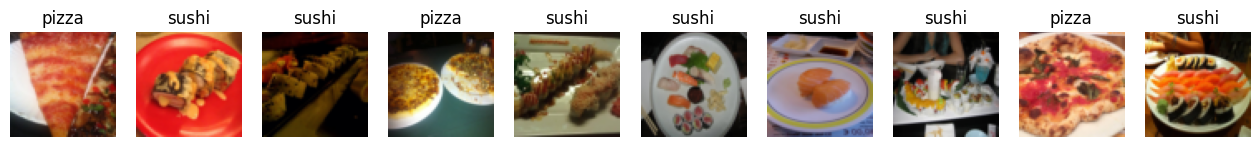

In [ ]:
display_rand_img(dataset=train_data_0,
                 k=10,
                 seed=42)


### 5.4 Turn `Dataset` to `DataLoader`

In [ ]:
from torch.utils.data import DataLoader

train_dataloader_0 = DataLoader(dataset=train_data_0,
                                batch_size=1,
                                shuffle=True,
                                num_workers=1)
test_dataloader_0 = DataLoader(dataset=test_data_0,
                                batch_size=1,
                                shuffle=False,
                                num_workers=1)
train_dataloader_0,test_dataloader_0

(<torch.utils.data.dataloader.DataLoader at 0x7fce4bec6da0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fce4bedcb80>)

In [ ]:
img_custom,label_custom = next(iter(train_dataloader_0))
img_custom.shape,label_custom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Data Augmentation

Artificially add diversity to training images...

In [ ]:
# Let's look at trivial augment
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

## 7. Model 0: TinyVGG without data augmentation

### 7.1 Creating transforms and loading data for Model 0

In [ ]:
from torchvision import transforms
# Creating transforms
simple_transforms = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

train_data_0 = ImageFolder(root=train_dir,
                           transform=simple_transforms,
                           target_transform=None)


train_dataloader_0 = DataLoader(dataset=train_data,
                                batch_size=1,
                                shuffle=True)

test_data_0 = ImageFolder(root=test_dir,
                           transform=simple_transforms,
                           target_transform=None)


test_dataloader_0 = DataLoader(dataset=test_data,
                                batch_size=1,
                                shuffle=False)

### 7.2 Building the Model

In [ ]:
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self,input_shape,output_shape,hidden_units):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x:torch.Tensor):
    return self.classifier(self.conv_block_2(self.conv_block_1(x)))

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  output_shape=3,
                  hidden_units=10).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from torchinfo import summary

summary(model_0,input_size=[1,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.3 Training and Testing steps

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  return (correct/len(y_pred))*100

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.001)

def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  return (correct/len(y_pred))*100

In [ ]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device,
               accuracy_fn):
  model.train()
  train_loss,train_acc = 0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device),y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
    loss = loss_fn(y_logit,y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss,train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device,
               accuracy_fn):
  test_loss,test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y  = X.to(device),y.to(device)
      y_logit = model(X)
      y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
      loss = loss_fn(y_logit,y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y,y_pred)
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss,test_acc

In [ ]:
from tqdm.auto import tqdm

def training_loop(model:torch.nn.Module,
                  train_dataloader:torch.utils.data.DataLoader,
                  test_dataloader:torch.utils.data.DataLoader,
                  loss_fn:torch.nn.Module,
                  optimizer:torch.optim.Optimizer,
                  device:torch.device,
                  accuracy_fn,
                  epochs:int=5):
  results = {"train loss":[],
             "train acc":[],
             "test loss":[],
             "test acc":[]
             }
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------")
    train_loss,train_acc = train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device,
               accuracy_fn=accuracy_fn)
    results["train loss"].append(train_loss)
    results["train acc"].append(train_acc)

    test_loss,test_acc = test_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               device=device,
               accuracy_fn=accuracy_fn)
    results["test loss"].append(test_loss)
    results["test acc"].append(test_acc)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
  results["model loss"] = test_loss
  results["model acc"] = test_acc
  results["model name"] = model.__class__.__name__
  return results

In [ ]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3,
                  output_shape=3,
                  hidden_units=10).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

In [ ]:
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)
timer_start = timer()
model_0_results = training_loop(model=model_0,
                                train_dataloader=train_dataloader_0,
                                test_dataloader=test_dataloader_0,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                accuracy_fn=accuracy_fn,
                                epochs=5)
timer_end = timer()
model_0_results["time"] = timer_end-timer_start

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-----------
Train loss: 1.10859 | Train acc: 32.89% | Test loss: 1.09838 | Test acc: 34.67%
Epoch: 1
-----------
Train loss: 1.09667 | Train acc: 38.22% | Test loss: 1.06575 | Test acc: 45.78%
Epoch: 2
-----------
Train loss: 1.04617 | Train acc: 54.67% | Test loss: 0.93443 | Test acc: 61.33%
Epoch: 3
-----------
Train loss: 0.95748 | Train acc: 60.44% | Test loss: 0.92232 | Test acc: 57.33%
Epoch: 4
-----------
Train loss: 0.92103 | Train acc: 60.00% | Test loss: 0.88821 | Test acc: 66.22%


In [ ]:
model_0_results

{'train loss': [1.1085897387398613,
  1.0966732345687018,
  1.0461671928564706,
  0.9574786305096414,
  0.9210275530401203],
 'train acc': [32.888888888888886,
  38.22222222222222,
  54.666666666666664,
  60.44444444444444,
  60.0],
 'test loss': [1.0983779123094346,
  1.0657463751898872,
  0.9344286572767628,
  0.9223202942063411,
  0.8882053177224265],
 'test acc': [34.666666666666664,
  45.77777777777778,
  61.333333333333336,
  57.333333333333336,
  66.22222222222223],
 'model loss': 0.8882053177224265,
 'model acc': 66.22222222222223,
 'model name': 'TinyVGG',
 'time': 14.639273437000156}

### 7.4 Plot Loss Curves

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
  loss = results["train loss"]
  acc = results["train acc"]
  test_loss = results["test loss"]
  test_acc = results["test acc"]
  epochs = list(range(len(loss)))
  plt.figure(figsize=(15,7))

  print(loss)

  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="Train Loss")
  plt.plot(epochs,test_loss,label="Test Loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(epochs,acc,label="Train Acc")
  plt.plot(epochs,test_acc,label="Test Acc")
  plt.title("Acc Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Acc")
  plt.legend()

[1.1085897387398613, 1.0966732345687018, 1.0461671928564706, 0.9574786305096414, 0.9210275530401203]


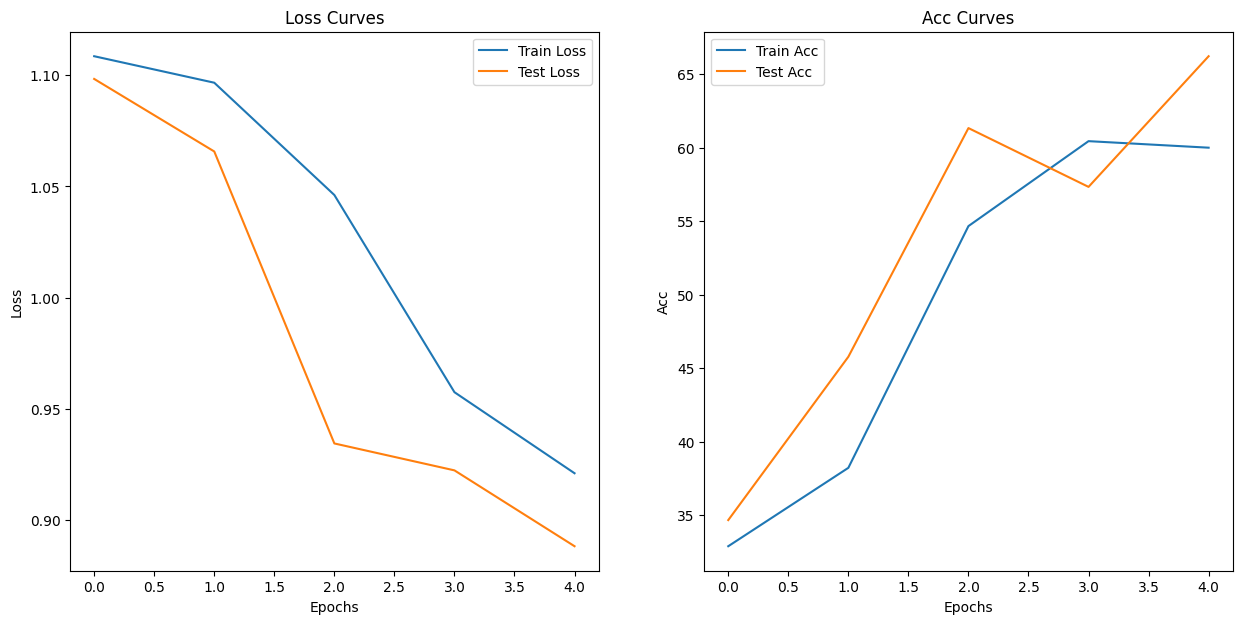

In [ ]:
plot_loss_curves(model_0_results)

## 8. What should a loss curve look like???

https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic


## 9. Model 1: TinyVGG with data augmentation

### 9.1 Creating transforms

In [ ]:
from torchvision import transforms

train_transforms_1 = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transforms_1 = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

### 9.2 Creating train and test datasets and data loaders

In [ ]:
from pathlib import Path
import requests
import zipfile

image_path = Path("data") / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"Already exists...")
else:
  print(f"Creating folder data...")
  image_path.mkdir(parents=True,exist_ok=True)

with open(image_path/"pizza_steak_sushi.zip","wb") as f:
  req = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  f.write(req.content)
  print(f"Downloading data...")

with zipfile.ZipFile(image_path/"pizza_steak_sushi.zip","r") as zipfile_ref:
  zipfile_ref.extractall(image_path)
  print(f"Extracting data...")


Already exists...
Extracting data...


In [ ]:
from torchvision.datasets import ImageFolder

train_dir = image_path /"train"
test_dir = image_path /"test"

train_dataset_1 = ImageFolder(root=train_dir,
                              transform=train_transforms_1)

test_dataset_1 = ImageFolder(root=test_dir,
                              transform=test_transforms_1)

In [ ]:
train_dataset_1,test_dataset_1

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                ToTensor()
            ))

In [ ]:
from torch.utils.data import DataLoader
import os

train_dataloader_1 = DataLoader(dataset=train_dataset_1,
                                batch_size=32,
                                shuffle=True,
                                num_workers=os.cpu_count())

test_dataloader_1 = DataLoader(dataset=test_dataset_1,
                                batch_size=32,
                                shuffle=False,
                                num_workers=os.cpu_count())
train_dataloader_1,test_dataloader_1

(<torch.utils.data.dataloader.DataLoader at 0x7fdde5494d30>,
 <torch.utils.data.dataloader.DataLoader at 0x7fdde54955d0>)

### 9.3 Build Model 1

In [ ]:
import torch
from torch import nn

class TinyVGG_1(nn.Module):
  def __init__(self,input_shape,output_shape,hidden_units):
    super().__init__()
    self.conv_layer_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                 out_channels=hidden_units,
                 kernel_size=3,
                 stride=1,
                 padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.conv_layer_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                 out_channels=hidden_units,
                 kernel_size=3,
                 stride=1,
                 padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,
                  out_features=output_shape)
    )

  def forward(self,x:torch.Tensor):
    return self.classifier(self.conv_layer_2(self.conv_layer_1(x)))

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

model_1 = TinyVGG_1(input_shape=3,
                    output_shape = 3,
                    hidden_units=10).to(device)
model_1

TinyVGG_1(
  (conv_layer_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_layer_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 9.4 Training our model

In [ ]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.001)

def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  return (correct/len(y_pred))*100

In [ ]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device:torch.device,
               accuracy_fn):
  model.train()
  train_loss,train_acc = 0,0
  for batch,(X,y) in enumerate(dataloader):
    X,y = X.to(device),y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
    loss = loss_fn(y_logit,y)
    train_loss += loss.item()
    train_acc += accuracy_fn(y,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss,train_acc

def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device:torch.device,
               accuracy_fn):
  test_loss,test_acc = 0,0
  model.eval()
  with torch.inference_mode():
    for batch,(X,y) in enumerate(dataloader):
      X,y  = X.to(device),y.to(device)
      y_logit = model(X)
      y_pred = torch.softmax(y_logit,dim=1).argmax(dim=1)
      loss = loss_fn(y_logit,y)
      test_loss += loss.item()
      test_acc += accuracy_fn(y,y_pred)
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss,test_acc

In [ ]:
from tqdm.auto import tqdm

def training_loop(model:torch.nn.Module,
                  train_dataloader:torch.utils.data.DataLoader,
                  test_dataloader:torch.utils.data.DataLoader,
                  loss_fn:torch.nn.Module,
                  optimizer:torch.optim.Optimizer,
                  device:torch.device,
                  accuracy_fn,
                  epochs:int=5):
  results = {"train loss":[],
             "train acc":[],
             "test loss":[],
             "test acc":[]
             }
  for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-----------")
    train_loss,train_acc = train_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               device=device,
               accuracy_fn=accuracy_fn)
    results["train loss"].append(train_loss)
    results["train acc"].append(train_acc)

    test_loss,test_acc = test_step(model=model,
               dataloader=train_dataloader,
               loss_fn=loss_fn,
               device=device,
               accuracy_fn=accuracy_fn)
    results["test loss"].append(test_loss)
    results["test acc"].append(test_acc)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}% | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}%")
  results["model loss"] = test_loss
  results["model acc"] = test_acc
  results["model name"] = model.__class__.__name__
  return results

In [ ]:
from timeit import default_timer as timer

torch.manual_seed(42)
torch.cuda.manual_seed(42)

timer_start = timer()

model_1_results = training_loop(model=model_1,
                                train_dataloader=train_dataloader_1,
                                test_dataloader=test_dataloader_1,
                                loss_fn=loss_fn,
                                optimizer=optimizer,
                                device=device,
                                accuracy_fn=accuracy_fn,
                                epochs=8)
timer_end = timer()
model_1_results["time"] = timer_end - timer_start

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch: 0
-----------
Train loss: 1.09686 | Train acc: 42.58% | Test loss: 1.09653 | Test acc: 42.58%
Epoch: 1
-----------
Train loss: 1.09688 | Train acc: 42.58% | Test loss: 1.09627 | Test acc: 42.58%
Epoch: 2
-----------
Train loss: 1.09802 | Train acc: 30.47% | Test loss: 1.09962 | Test acc: 30.47%
Epoch: 3
-----------
Train loss: 1.09660 | Train acc: 42.58% | Test loss: 1.09799 | Test acc: 30.47%
Epoch: 4
-----------
Train loss: 1.09953 | Train acc: 30.47% | Test loss: 1.09908 | Test acc: 30.47%
Epoch: 5
-----------
Train loss: 1.09774 | Train acc: 30.47% | Test loss: 1.09905 | Test acc: 30.47%
Epoch: 6
-----------
Train loss: 1.09785 | Train acc: 30.47% | Test loss: 1.09703 | Test acc: 42.58%
Epoch: 7
-----------
Train loss: 1.09662 | Train acc: 42.58% | Test loss: 1.09651 | Test acc: 42.58%


In [ ]:
model_1_results

{'train loss': [1.0968616902828217,
  1.096878096461296,
  1.0980190485715866,
  1.0965956896543503,
  1.099532201886177,
  1.0977446734905243,
  1.0978542119264603,
  1.0966219007968903],
 'train acc': [42.578125,
  42.578125,
  30.46875,
  42.578125,
  30.46875,
  30.46875,
  30.46875,
  42.578125],
 'test loss': [1.0965318828821182,
  1.0962735563516617,
  1.0996153354644775,
  1.0979938060045242,
  1.0990823805332184,
  1.0990538001060486,
  1.0970287770032883,
  1.0965093076229095],
 'test acc': [42.578125,
  42.578125,
  30.46875,
  30.46875,
  30.46875,
  30.46875,
  42.578125,
  42.578125],
 'model loss': 1.0965093076229095,
 'model acc': 42.578125,
 'model name': 'TinyVGG_1',
 'time': 21.739147340000272}

### 9.5 Plot loss curves

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
  loss = results["train loss"]
  acc = results["train acc"]
  test_loss = results["test loss"]
  test_acc = results["test acc"]
  epochs = list(range(len(loss)))
  plt.figure(figsize=(15,7))

  print(loss)

  plt.subplot(1,2,1)
  plt.plot(epochs,loss,label="Train Loss")
  plt.plot(epochs,test_loss,label="Test Loss")
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()


  plt.subplot(1,2,2)
  plt.plot(epochs,acc,label="Train Acc")
  plt.plot(epochs,test_acc,label="Test Acc")
  plt.title("Acc Curves")
  plt.xlabel("Epochs")
  plt.ylabel("Acc")
  plt.legend()

[1.0968616902828217, 1.096878096461296, 1.0980190485715866, 1.0965956896543503, 1.099532201886177, 1.0977446734905243, 1.0978542119264603, 1.0966219007968903]


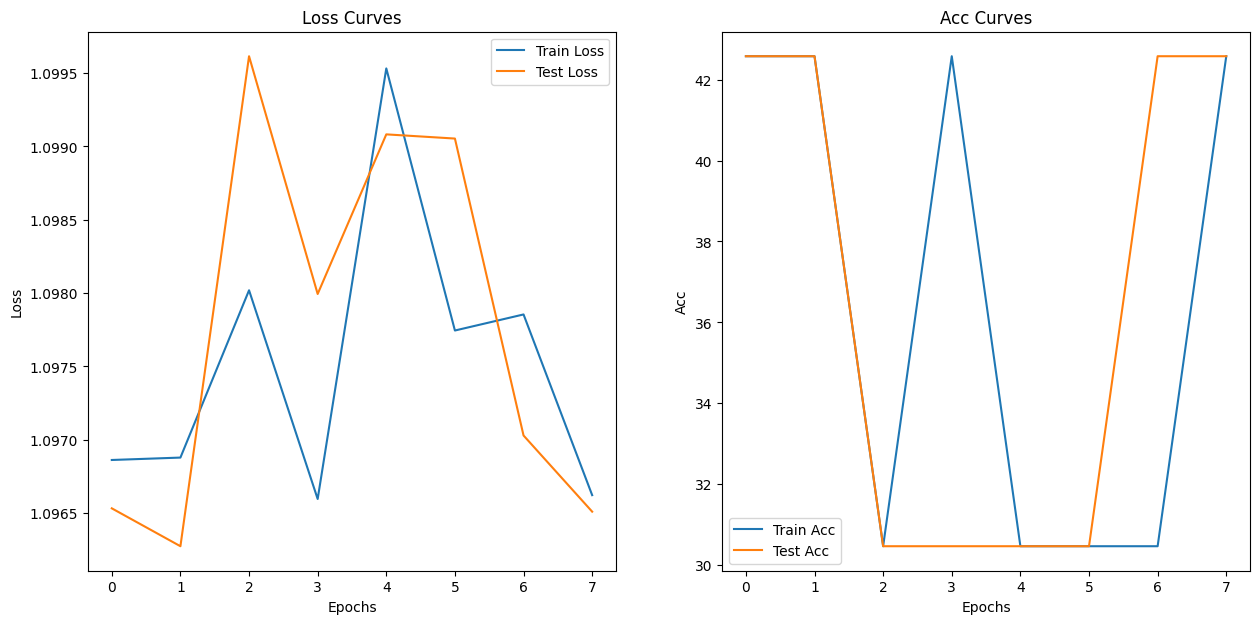

In [ ]:
plot_loss_curves(model_1_results)

## 10. Compare Model Results

* PyTorch + tensorboard
* Weights and biases
* MLFlow

In [ ]:
import pandas as pd

model_1_df = pd.DataFrame(model_1_results)

model_1_df

,train loss,train acc,test loss,test acc,model loss,model acc,model name,time
0,1.096862,42.578125,1.096532,42.578125,1.099082,30.46875,TinyVGG_1,12.85821
1,1.096878,42.578125,1.096274,42.578125,1.099082,30.46875,TinyVGG_1,12.85821
2,1.098019,30.468750,1.099615,30.468750,1.099082,30.46875,TinyVGG_1,12.85821
3,1.096596,42.578125,1.097994,30.468750,1.099082,30.46875,TinyVGG_1,12.85821
4,1.099532,30.468750,1.099082,30.468750,1.099082,30.46875,TinyVGG_1,12.85821
